In [2]:
using Plots, FileIO, Images, Plots.PlotMeasures

In [3]:
using JLD

In [4]:
deg = 3 # deg(f)

3

In [5]:
q=128

128

In [6]:
lambda = exp(2*pi*im/q)

0.9987954562051724 + 0.049067674327418015im

In [7]:
f(z) = lambda * z * (1+z)^2

f (generic function with 1 method)

In [8]:
function fn(n,z)
    for i=1:n
        z=f(z)
    end
    return z
end

fn (generic function with 1 method)

In [9]:
df(z) = lambda*(1+z)*(1+3*z)

df (generic function with 1 method)

In [10]:
function fdf(z)
    t = 1+z
    s= lambda*t
    return s*z*t, s*(1+3*z);
end
    

fdf (generic function with 1 method)

In [11]:
fp = exp(-pi*im/q)-1

-0.00030118130379575003 - 0.024541228522912288im

In [12]:
f(fp)-fp

-1.0842021724855044e-19 + 0.0im

In [13]:
tau(z) = z/(z-fp)

tau (generic function with 1 method)

In [14]:
tauinv(w) = fp*w/(w-1)

tauinv (generic function with 1 method)

In [15]:
function isEscaping(z,R2)
    if (abs2(z)>R2)
        return true, log(k)
    end
    return false, -1
end
        

isEscaping (generic function with 1 method)

In [16]:
# for small iterations (dz = (f^k)'(z)/deg^k
function isEscaping_Green(k, z, dz, R2, minmetric)
    l = abs2(z)
    if (l>R2) # escaping case
        g=log(l)/(2*deg^k)
        dg = abs(dz)/abs(z)
        return true, (dg/sinh(g)>minmetric) ? -100 : -50
    end
    return false, -1
end

isEscaping_Green (generic function with 1 method)

In [17]:
# for large iterations (dz = (f^k)'(z) )
function isEscaping_Green2(z, dz, R2, minmetric)
    l = abs2(z)

    if (l>R2) # escaping case
        g = log(l)/2
        dg = abs(dz)/abs(z)
        metric = dg/g; # deg^k sinh(g/deg^k) is close to g when k is large
        return true, (metric>minmetric) ? -100 : -50
    end
    return false, -1
end

isEscaping_Green2 (generic function with 1 method)

In [18]:
function inAttrPetal(z, eps2, angle0, eta)
    w = tau(z)
    l2 = abs2(w)
    if (l2 < eps2) # near the parabolic fixed point
        theta = (angle(w)-angle0)/(2*pi)*q
        #if (abs(theta-round(theta))<eta) # in the petals (seems not working properly for large q)
        if (abs(theta)<eta) # in the (specific) petal
            p = round(theta)
            return true, p
        end
    end
    return false, -1
end

inAttrPetal (generic function with 1 method)

In [19]:
function Julia(xmin, xmax, ymin, ymax, width, height; maxiter = 100, R = 10)
    R2 = R^2
    xrange = range(xmin, xmax, length=width)
    yrange = range(ymin, ymax, length=height)

    zrange = complex.(xrange', yrange)

    function iter(z)
        for k=1:maxiter
            z = f(z)
            if (abs2(z)>R2)
                return log(k)
            end
        end
        return -1
    end

    mesh = map(iter, zrange);

    return xrange, yrange, mesh
end


Julia (generic function with 1 method)

In [19]:
xrange, yrange, mesh = Julia(-2.25,0.75,-1.5,1.5,800,800, maxiter=1000)

(-2.25:0.0037546933667083854:0.75, -1.5:0.0037546933667083854:1.5, Real[0.0 0.0 … 0.6931471805599453 0.6931471805599453; 0.0 0.0 … 0.6931471805599453 0.6931471805599453; … ; 0.0 0.0 … 0.6931471805599453 0.6931471805599453; 0.0 0.0 … 0.6931471805599453 0.6931471805599453])

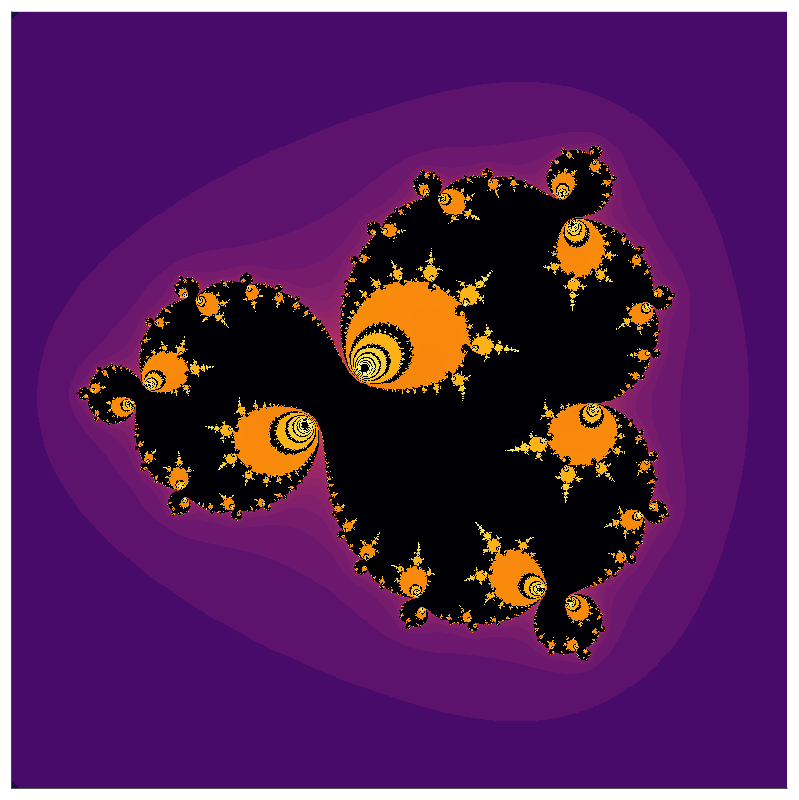

In [20]:
heatmap(xrange, yrange, mesh, size=(800,800), colorbar=false, ticks=false, frame=false)

In [41]:
function Julia_by_Green(xmin, xmax, ymin, ymax, width, height; maxiter1 = 30, maxiter2=500, minmetric = 10000, R = 100, eps = 0.001, eta=0.4)
    R2 = R^2
    eps2 = eps^2


    xrange = range(xmin, xmax, length=width)
    yrange = range(ymin, ymax, length=height)

    zrange = complex.(xrange', yrange)


    z=-1/3 # critical point in the parabolic basin
    #while(abs2(z)>=eps2)
    k0=1000000
    for i=1:k0
        z = f(z)
    end

    angle0 = angle(tau(z)); # an attracting direction at 0 (in tau-coordinate)
    #angle0 -= 0.3*2*pi/100; # adjustment (by hand)

    # compute hyperbolic metric in the escape region
    function iter(z) 
        dz = 1

        # fast escaping case
        for k=1:maxiter1
            z, t = fdf(z)
            dz *= t/deg # dz = (f^k)'(z)/deg^k indeed

            escaping, nearJ = isEscaping_Green(k, z, dz, R2, minmetric)
            
            if (escaping)
                return nearJ;
            end

            inAttr, p = inAttrPetal(z, eps2, angle0, eta)

            if (inAttr)
                #return ((p-k+maxiter2) % q);
                j= (k0 - (p-k)) % q;
                return (j==0) ? 50 : 0
            end

        end

        # slow escaping (=not so expanding) case
        dz *= deg^maxiter1; 

        for k=(maxiter1+1):maxiter2
            z, t = fdf(z)
            dz *= t

            escaping, nearJ = isEscaping_Green2(z, dz, R2, minmetric)
            
            if (escaping)
                return nearJ;
            end

            inAttr, p = inAttrPetal(z, eps2, angle0, eta)

            if (inAttr)
                #return ((p-k+maxiter2) % q);
                j= (k0 - (p-k)) % q;
                return (j==0) ? 50 : 0
            end

        end

        return -150
    end

    mesh = map(iter, zrange);

    return xrange, yrange, mesh
end

Julia_by_Green (generic function with 1 method)

In [46]:
xrange, yrange, mesh = Julia_by_Green(-2.25,0.75,-1.5,1.5,2048,2048, minmetric=200, maxiter1=30, maxiter2=50000, eps=0.95, eta=0.4)

(-2.25:0.0014655593551538837:0.75, -1.5:0.0014655593551538837:1.5, [-50 -50 … -50 -50; -50 -50 … -50 -50; … ; -50 -50 … -50 -50; -50 -50 … -50 -50])

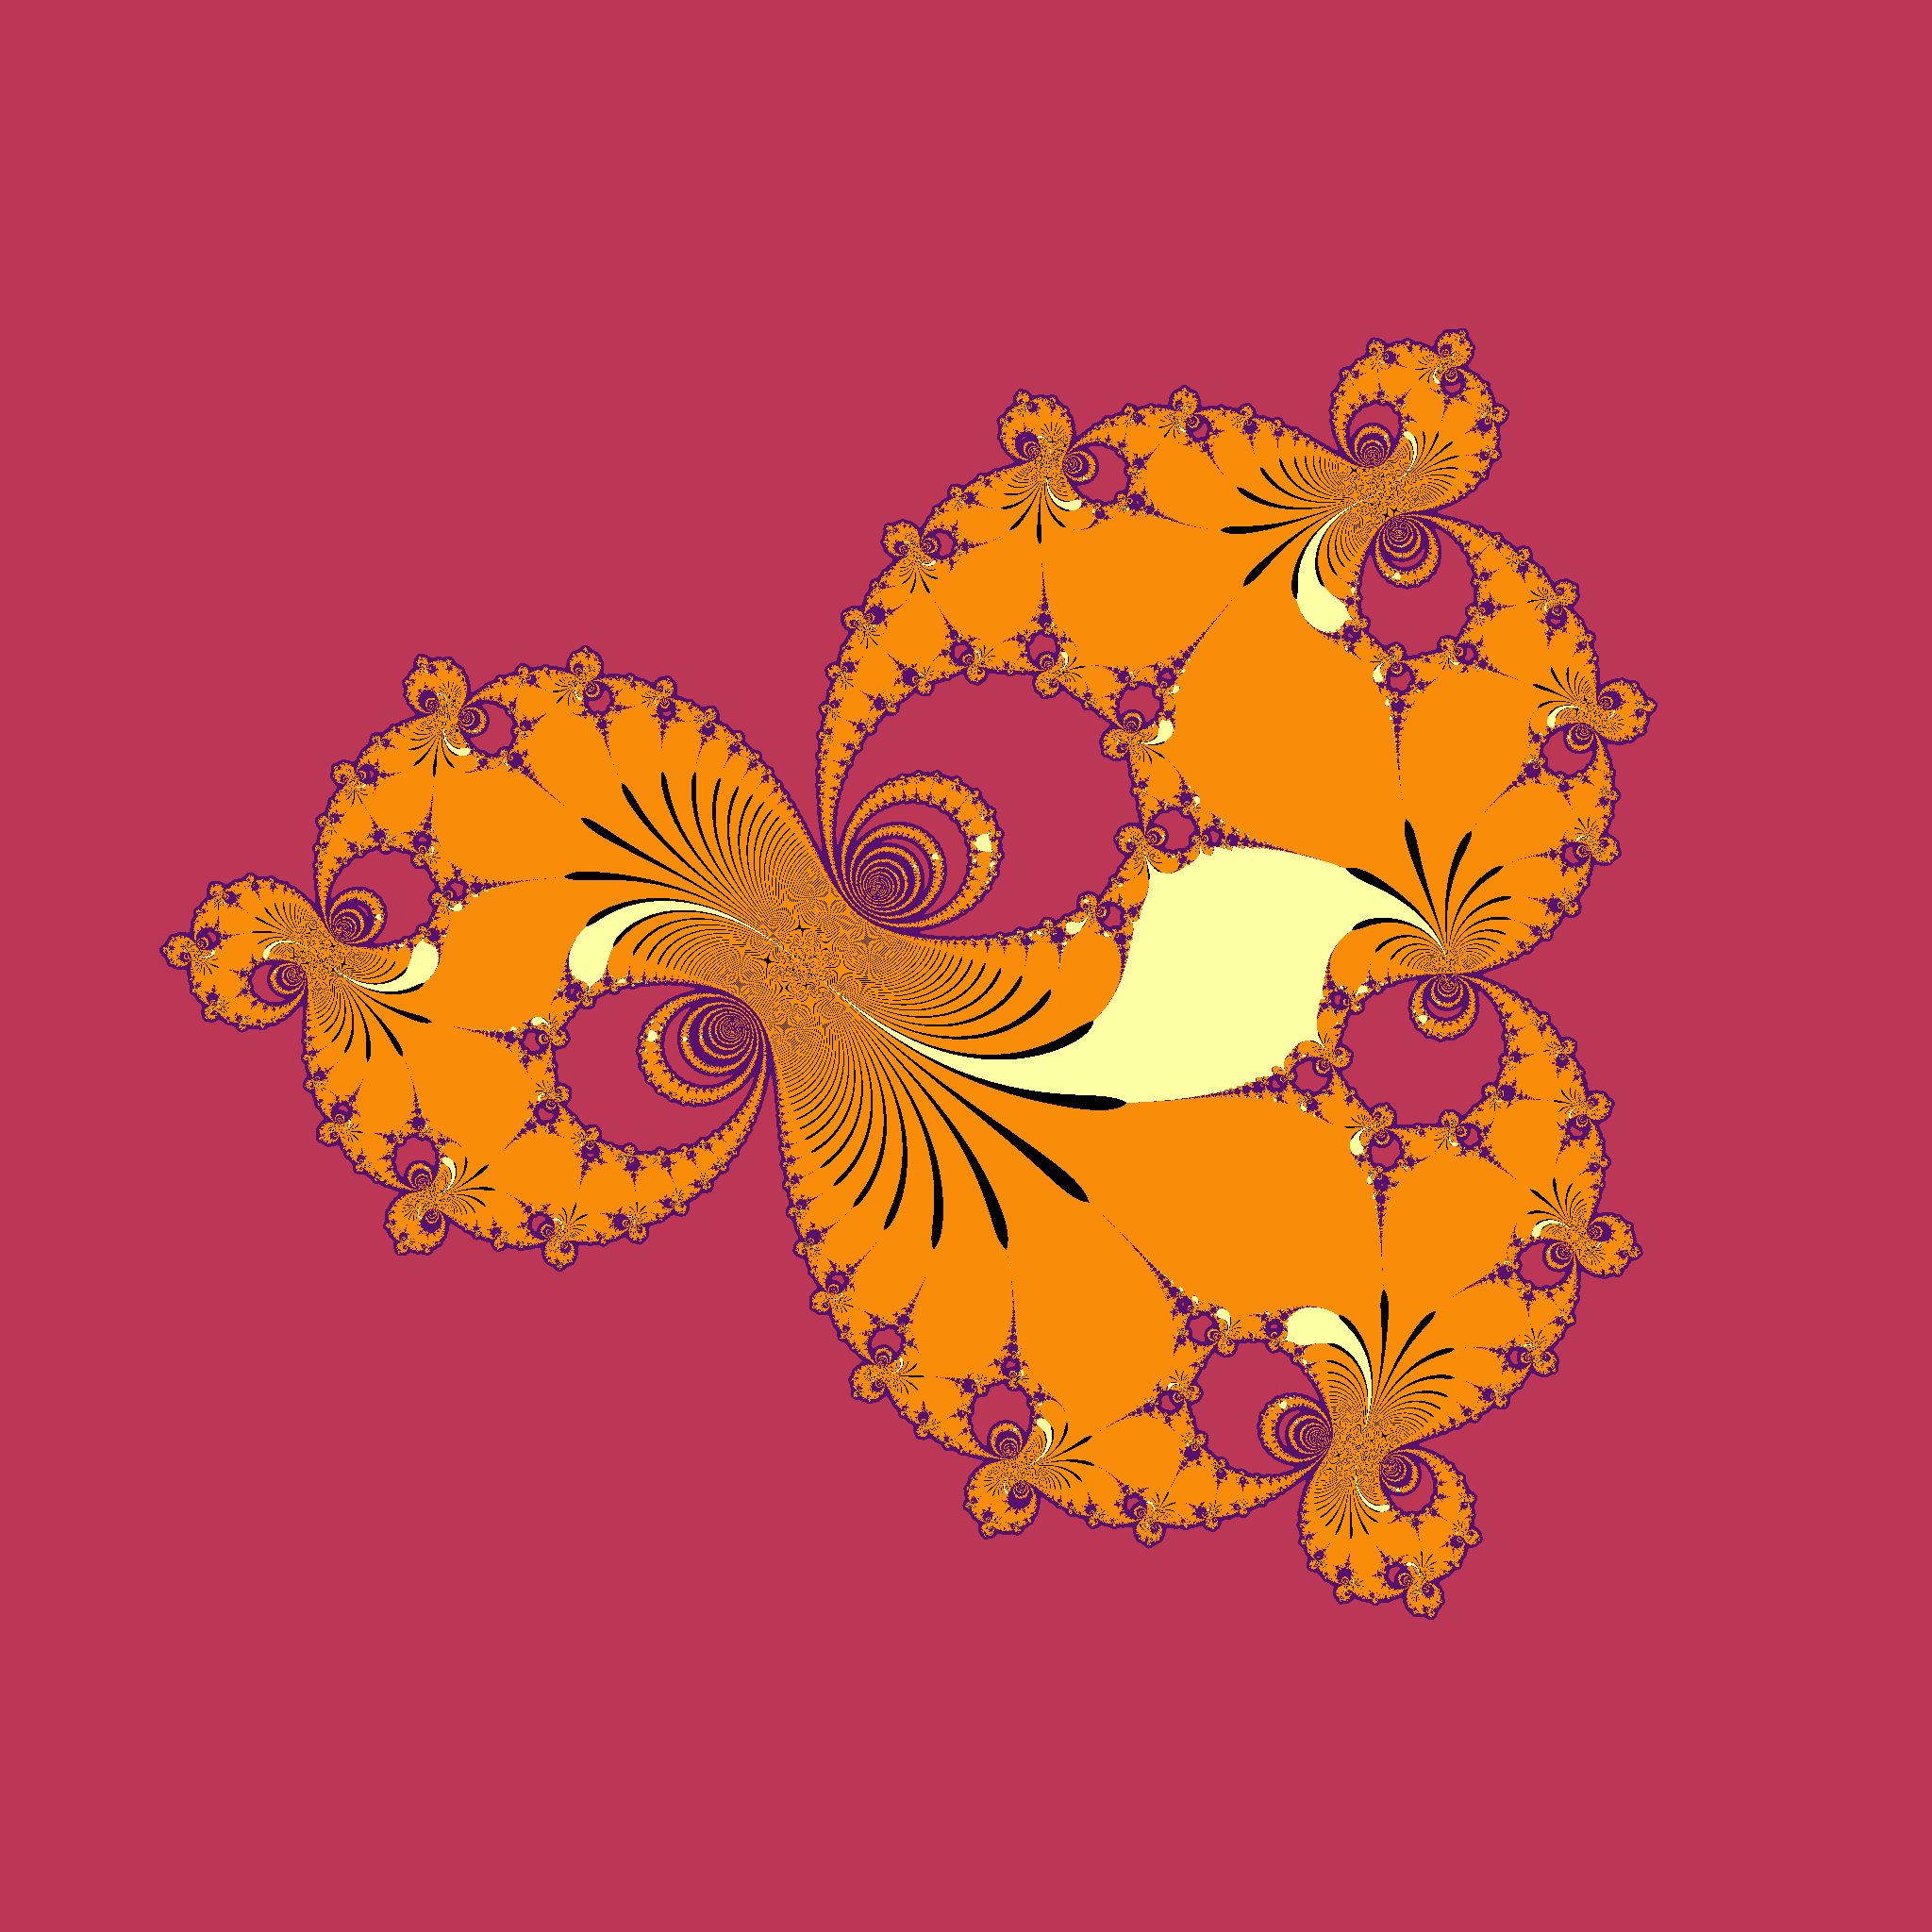

In [47]:
fig = heatmap(xrange, yrange, mesh, size=(2048,2048), colorbar=false, ticks=false, frame=false, margins=-2mm)

In [48]:
savefig("out128-2048x2048_50000.png")

"/Users/inou/Documents/jupyter/JuliaJulia/out128-2048x2048_50000.png"

In [49]:
save("out128-2048x2048_50000.jld", "xrange", xrange, "yrange", yrange, "mesh", mesh);

In [44]:
xrange2, yrange2, mesh2 = Julia_by_Green(-2.25,0.75,-1.5,1.5,400,400, minmetric=100, maxiter1=30, maxiter2=5000, eps=0.95, eta=0.4)

(-2.25:0.007518796992481203:0.75, -1.5:0.007518796992481203:1.5, [-50 -50 … -50 -50; -50 -50 … -50 -50; … ; -50 -50 … -50 -50; -50 -50 … -50 -50])

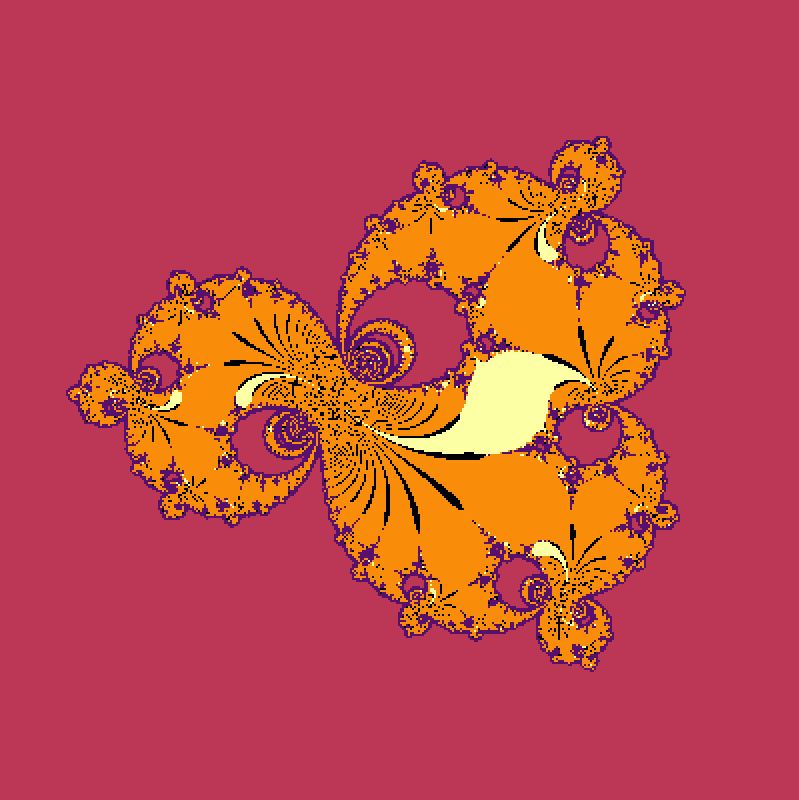

In [45]:
heatmap(xrange2, yrange2, mesh2, size=(800,800), margins=-2mm, colorbar=false, ticks=false, frame=false)

In [46]:
savefig("out100-800x800_5000.png")

"/Users/inou/Documents/jupyter/JuliaJulia/out100-800x800_10000.png"

In [67]:
function Julia_by_Green_log_coord(xmin, xmax, ymin, ymax, width, height; maxiter1 = 30, maxiter2=500, minmetric = 10000, R = 100, eps = 0.01, eta=0.4)
    deg = 3 # deg(f)
    R2 = R^2
    eps2 = eps^2

    xrange = range(xmin, xmax, length=width)
    yrange = range(ymin, ymax, length=height)

    zrange = complex.(xrange', yrange)


    z=-1/3 # critical point in the parabolic basin
    while (abs2(tau(z))>=eps2)
        z = f(z)
    end
    
    angle0 = angle(tau(z)); # an attracting direction at 0 (in tau-coordinate)

    # compute hyperbolic metric in the escape region
    function iter(z) 
        z = exp(z)
        dz = 1

        # fast escaping case
        for k=1:maxiter1
            z, t = fdf(z)
            dz *= t/deg # dz = (f^k)'(z)/deg^k indeed

            escaping, nearJ = isEscaping_Green(k, z, dz, R2, minmetric)
            
            if (escaping)
                return nearJ;
            end

            inAttr, p = inAttrPetal(z, eps2, angle0, eta)

            if (inAttr)
                return ((p-k+maxiter2) % q);
            end

        end

        # slow escaping (=not so expanding) case
        dz *= deg^maxiter1; 

        for k=(maxiter1+1):maxiter2
            z, t = fdf(z)
            dz *= t

            escaping, nearJ = isEscaping_Green2(z, dz, R2, minmetric)
            
            if (escaping)
                return nearJ;
            end

            inAttr, p = inAttrPetal(z, eps2, angle0, eta)

            if (inAttr)
                return ((p-k+maxiter2) % q);
            end
            
        end

        return -150
    end

    mesh = map(iter, zrange);

    return xrange, yrange, mesh
end

Julia_by_Green_log_coord (generic function with 1 method)

In [127]:
xrange3, yfrange3, mesh3 = Julia_by_Green_log_coord(-1.3*pi-pi/20, -1.3*pi+pi/20, -pi/20, pi/20, 400, 400, minmetric=100, maxiter1=30, maxiter2=45,eps=0.7, eta=0.1)

(-4.241150082346221:0.0007873665798470659:-3.9269908169872414, -0.15707963267948966:0.0007873665798470659:0.15707963267948966, Real[-150 -150 … 25.0 25.0; -150 -150 … 25.0 25.0; … ; 27.0 27.0 … -150 -150; 27.0 27.0 … -150 -150])

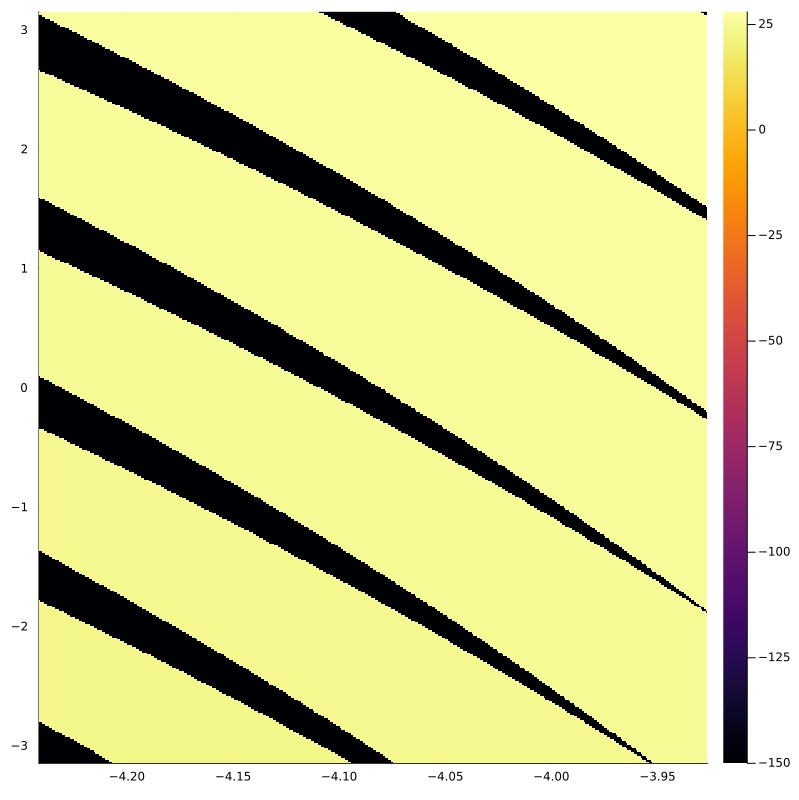

In [128]:
heatmap(xrange3, yrange3, mesh3, size=(800,800))#, margins=-2mm, ticks=false, frame=false)

In [86]:
exp(im*pi)

-1.0 + 1.2246467991473532e-16im

In [68]:
function Julia_by_Green_tau_coord(xmin, xmax, ymin, ymax, width, height; maxiter1 = 30, maxiter2=500, minmetric = 10000, R = 100, eps = 0.1, eta=0.4)
    deg = 3 # deg(f)
    R2 = R^2
    eps2 = eps^2

    xrange = range(xmin, xmax, length=width)
    yrange = range(ymin, ymax, length=height)

    zrange = complex.(xrange', yrange)


    k=0
    z=-1/3 # critical point in the parabolic basin
    while (abs2(tau(z))>=eps2)
        z = f(z)
        k += 1
    end
    
    println(k)
    
    #angle0=angle(z)
    angle0 = angle(tau(z)); # an attracting direction at 0 (in tau-coordinate)

    # compute hyperbolic metric in the escape region
    function iter(z) 
        z = tauinv(z)
        dz = 1

        # fast escaping case
        for k=1:maxiter1
            z, t = fdf(z)
            dz *= t/deg # dz = (f^k)'(z)/deg^k indeed
            
            escaping, nearJ = isEscaping_Green(k, z, dz, R2, minmetric)
            
            if (escaping)
                return nearJ;
            end

            inAttr, p = inAttrPetal(z, eps2, angle0, eta)

            if (inAttr)
                return (p == 0) ? 50 : ((p-k+maxiter2) % q);
            end

        end

        # slow escaping (=not so expanding) case
        dz *= deg^maxiter1; 

        if (maxiter2 > maxiter1) 
            for k=(maxiter1+1):maxiter2
                z, t = fdf(z)
                dz *= t

                escaping, nearJ = isEscaping_Green2(z, dz, R2, minmetric)
                
                if (escaping)
                    return nearJ;
                end

                inAttr, p = inAttrPetal(z, eps2, angle0, eta)

                if (inAttr)
                    return ((p-k+maxiter2) % q);
                end
                
            end
        end

        return -150
    end

    mesh = map(iter, zrange);

    return xrange, yrange, mesh
end

Julia_by_Green_tau_coord (generic function with 1 method)

In [118]:
r1=0.95; r2 = 1; xrange4, yrange4, mesh4 = Julia_by_Green_tau_coord(-r2,r2,-r2,r2,400,400, minmetric=100, maxiter1=30, maxiter2=10000, eps=r1, eta=0.4)

31


(-1.0:0.005012531328320802:1.0, -1.0:0.005012531328320802:1.0, [-100 -100 … -100 -100; -100 -100 … -100 -100; … ; -100 -100 … 50 50; -100 -100 … 50 50])

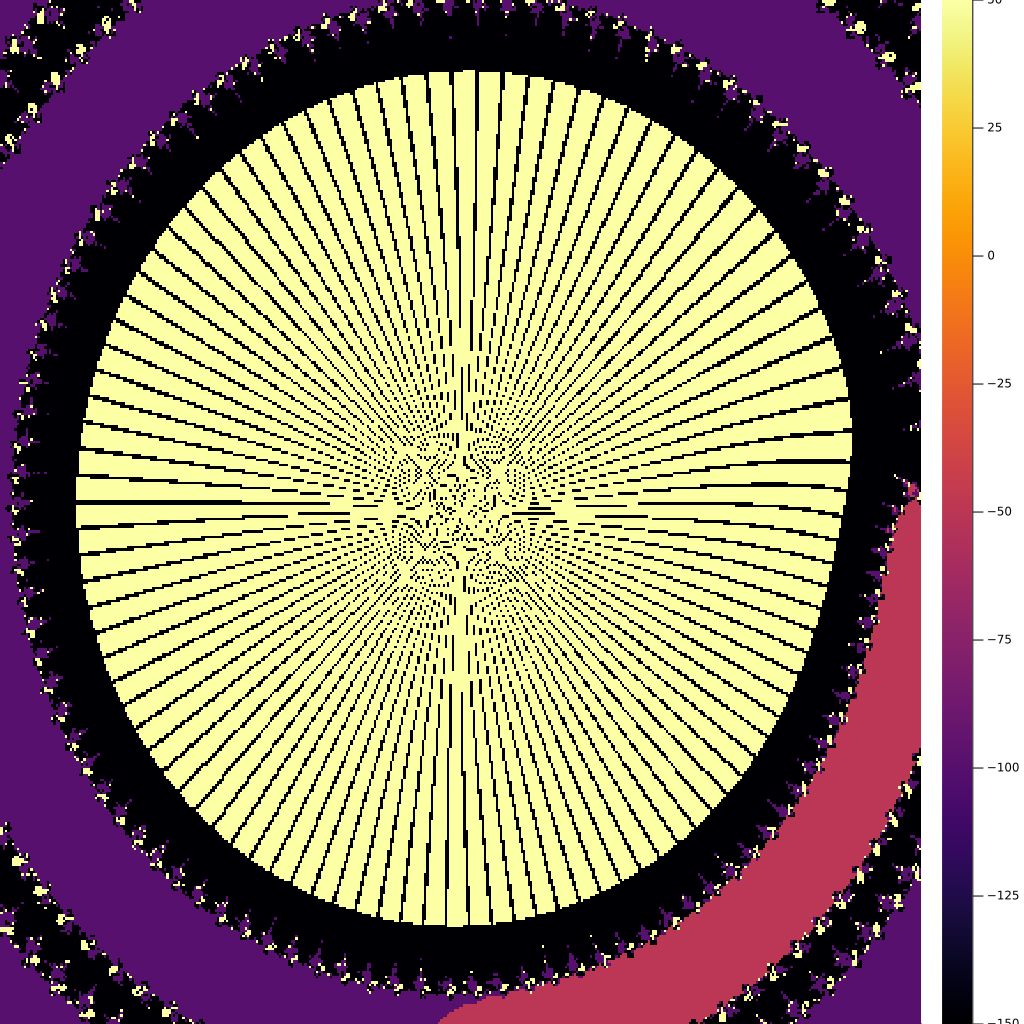

In [106]:
heatmap(xrange4, yrange4, mesh4, size=(1024,1024), margins=-2mm, ticks=false, frame=false)

In [94]:
z=-0.01; tau(fn(100,tauinv(z)))/z

1.000000000000001 + 4.0843912987941876e-17im

In [95]:
z=-0.01*exp(2*pi*im/100); tau(fn(100,tauinv(z)))/z

0.9999999999999996 - 1.1578071394617698e-15im

In [93]:
log(tau(fn(100,tauinv(0.1)))/0.1)/(2*pi)

5.300924469105853e-16 - 3.1511386266254796e-17im

In [40]:
1000000 % q


64